# Initialising




---






In [1]:
# installing AIcrowd CLI
!pip install aicrowd-cli
%load_ext aicrowd.magic

In [2]:
%aicrowd login

Please login here: https://api.aicrowd.com/auth/uvcKLcWSlS8wHMUsF7sJENmjzPZ6GM9hWG2oE98fYRQ
API Key valid
Saved API Key successfully!


In [3]:
# Downloading the Dataset
!rm -rf data
!mkdir data
%aicrowd ds dl -c fake-news-detection -o data

train.zip:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

test.zip:   0%|          | 0.00/16.6M [00:00<?, ?B/s]

sample_submission.csv:   0%|          | 0.00/580k [00:00<?, ?B/s]

val.zip:   0%|          | 0.00/5.56M [00:00<?, ?B/s]

In [4]:
!unzip data/train -d data/train > /dev/null
!unzip data/test -d data/test > /dev/null

In [5]:
# reading in train, test, val files
import pandas as pd
import os
train_df = pd.read_csv(os.path.join("data", "train", "train.csv"))
print(train_df.head())

test_df = pd.read_csv(os.path.join("data", "test", "test.csv"))
print(test_df.head())

!unzip data/val -d data/val > /dev/null
val_df = pd.read_csv(os.path.join("data", "val", "val.csv"))
print(val_df.head())

                                                text label
0  The court granted by a 5-4 vote a request made...  real
1  " Pennsylvania was a crucial swing state in th...  real
2  The company today is rolling out an update to ...  fake
3  When it comes to trade policy, Hillary Clinton...  real
4  S. stocks had their worst April start since 19...  real
                                                text
0  We asked for "disclosure of any information th...
1  Continued disruptions by a range of local grou...
2  Criminal gangs in China are faking outbreaks o...
3  "After we announced the Hess transaction, we h...
4  A Syngenta spokesman clarified his comment ear...
                                                text label
0  Police investigating Saturday's fatal shooting...  real
1  A car bomb in Turkey's eastern province of Ela...  real
2  Democratic presidential candidate Hillary Clin...  real
3  Generally, each party gets two turns to decide...  fake
4  Securitas CEO Alf Goransson to

# ✔ Method 4: RNN

In [60]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import tensorflow as tf 
import re 
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns 
plt.style.use('ggplot')

In [45]:
train_df

,text,label
0,The court granted by a 5-4 vote a request made...,1
1,""" Pennsylvania was a crucial swing state in th...",1
2,The company today is rolling out an update to ...,0
3,"When it comes to trade policy, Hillary Clinton...",1
4,S. stocks had their worst April start since 19...,1
...,...,...
231998,Cipher Pharmaceuticals Inc * Cipher pharmaceut...,1
231999,Lyft and larger rival Uber face separate lawsu...,1
232000,Six-month Sterling Overnight Index Average (SO...,1
232001,Going on Museum Hack's Badass Bitches tour -- ...,0


In [46]:
val_df

,text,label
0,Police investigating Saturday's fatal shooting...,1
1,A car bomb in Turkey's eastern province of Ela...,1
2,Democratic presidential candidate Hillary Clin...,1
3,"Generally, each party gets two turns to decide...",0
4,Securitas CEO Alf Goransson told Reuters: * Se...,1
...,...,...
38661,"His mother and sister, who were outside, also ...",1
38662,".. continue to work for political solution, co...",1
38663,"Dominic Raab, a candidate to replace British P...",1
38664,Japan's Fujitsu Ltd and China's Lenovo Group L...,1


In [47]:
full_df

,text,label
0,the dollar was percent higher at yen follo...,1
1,investigation of bribery surrounding fifa soc...,0
2,britain has notified the organisation for the ...,1
3,trade representative robert lighthizer who is...,1
4,harmonic inc harmonic inc limited liabilit...,0
...,...,...
270664,china will build a railway connecting the west...,1
270665,reflect the concerns of utah and reflect t...,1
270666,u s gold futures too slipped to an o...,1
270667,apple inc launched its apple pay software in r...,1


In [48]:
features = full_df['text']
targets = full_df['label']

X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.20, random_state=18)

In [49]:
# normalizing our data
def normalize(data):
    normalized = []
    for i in data:
        i = i.lower()
        # get rid of urls
        i = re.sub('https?://\S+|www\.\S+', '', i)
        # get rid of non words and extra spaces
        i = re.sub('\\W', ' ', i)
        i = re.sub('\n', '', i)
        i = re.sub(' +', ' ', i)
        i = re.sub('^ ', '', i)
        i = re.sub(' $', '', i)
        normalized.append(i)
    return normalized

X_train = normalize(X_train)
X_test = normalize(X_test)

In [50]:
max_vocab = 10000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train)

In [52]:
# converting text to vectors
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [53]:
# applying padding
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=256)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=256)

In [54]:
# building the RNN

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab, 32),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          320000    
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        49664     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               18560     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6

In [57]:
# using early stop which stops when the validation loss no longer improves

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10,validation_split=0.1, batch_size=30, shuffle=True, callbacks=[early_stop])

Epoch 1/10
6497/6497 [==============================] - 1423s 218ms/step - loss: 0.1512 - accuracy: 0.9435 - val_loss: 0.1239 - val_accuracy: 0.9531
Epoch 2/10
6497/6497 [==============================] - 1409s 217ms/step - loss: 0.1097 - accuracy: 0.9594 - val_loss: 0.1191 - val_accuracy: 0.9571
Epoch 3/10
6497/6497 [==============================] - 1412s 217ms/step - loss: 0.0914 - accuracy: 0.9665 - val_loss: 0.1124 - val_accuracy: 0.9577
Epoch 4/10
6497/6497 [==============================] - 1414s 218ms/step - loss: 0.0780 - accuracy: 0.9723 - val_loss: 0.1147 - val_accuracy: 0.9590
Epoch 5/10
6497/6497 [==============================] - 1412s 217ms/step - loss: 0.0659 - accuracy: 0.9766 - val_loss: 0.1264 - val_accuracy: 0.9584


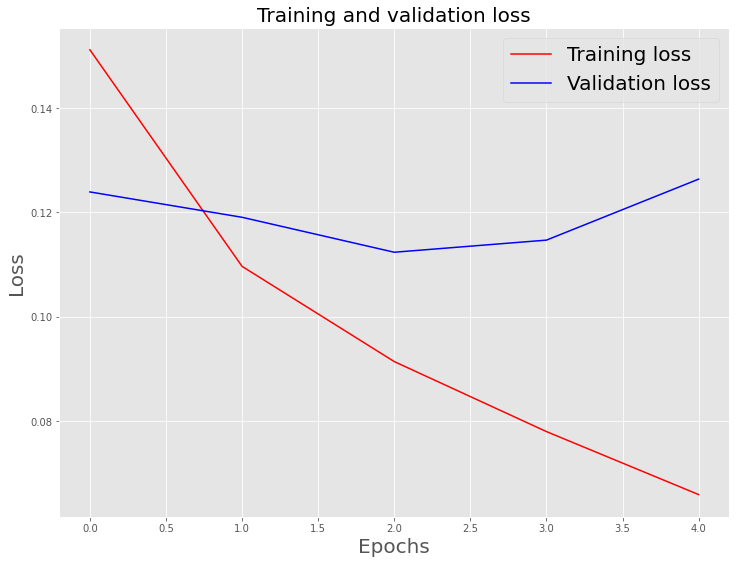

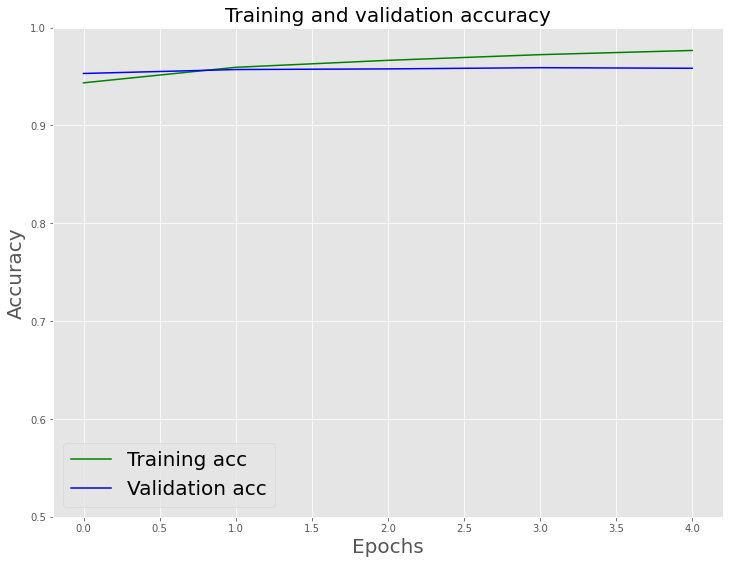

In [58]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()

In [59]:
model.evaluate(X_test, y_test)

1692/1692 [==============================] - 158s 93ms/step - loss: 0.1083 - accuracy: 0.9590


[0.10831813514232635, 0.9590460658073425]

In [61]:
pred = model.predict(X_test)

binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0) 

In [62]:
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))
print('F1 Score on testing set:', f1_score(binary_predictions, y_test))

Accuracy on testing set: 0.9590460708611963
Precision on testing set: 0.9693278620403075
Recall on testing set: 0.9729919966631039
F1 Score on testing set: 0.9711564732055736


In [64]:
len(binary_predictions)

54134

In [84]:
# applying the code to submission
test_df3 = pd.read_csv(os.path.join("data", "test", "test.csv"))
process_df3 = pd.read_csv(os.path.join("data", "test", "test.csv"))
print(test_df3.head())
print(process_df3.head())

                                                text
0  We asked for "disclosure of any information th...
1  Continued disruptions by a range of local grou...
2  Criminal gangs in China are faking outbreaks o...
3  "After we announced the Hess transaction, we h...
4  A Syngenta spokesman clarified his comment ear...
                                                text
0  We asked for "disclosure of any information th...
1  Continued disruptions by a range of local grou...
2  Criminal gangs in China are faking outbreaks o...
3  "After we announced the Hess transaction, we h...
4  A Syngenta spokesman clarified his comment ear...


In [85]:
# normalizing our data
def normalize(data):
    normalized = []
    for i in data:
        i = i.lower()
        # get rid of urls
        i = re.sub('https?://\S+|www\.\S+', '', i)
        # get rid of non words and extra spaces
        i = re.sub('\\W', ' ', i)
        i = re.sub('\n', '', i)
        i = re.sub(' +', ' ', i)
        i = re.sub('^ ', '', i)
        i = re.sub(' $', '', i)
        normalized.append(i)
    return normalized

In [86]:
process_df3 = normalize(process_df3["text"])

In [87]:
process_df3

['we asked for disclosure of any information that may be relevant to the investigation a spokesman for the department of justice declined to comment on the probe saying only that it was ongoing',
 'continued disruptions by a range of local groups demanding a share of the revenues as well as a lack of funds for maintenance and investment are preventing the national oil corporation noc from consolidating those gains oil officials',
 'criminal gangs in china are faking outbreaks of african swine fever on farms free of the disease and forcing farmers to sell their healthy pigs at sharply lower prices the agriculture ministry said on friday the gangs are taking advantage of a highly contagious disease that has spread across much of the country and disrupted the world s biggest pork market the',
 'after we announced the hess transaction we have seen strong interest to partner with aker bp in the valhall area through this transaction we get a partner that shares our ambition of developing the

In [88]:
process_df3 = tokenizer.texts_to_sequences(process_df3)

In [89]:
process_df3 = tf.keras.preprocessing.sequence.pad_sequences(process_df3, padding='post', maxlen=256)

In [91]:
pred2 = model.predict(process_df3)

binary_predictions2 = []

for i in pred2:
    if i >= 0.5:
        binary_predictions2.append(1)
    else:
        binary_predictions2.append(0) 

In [92]:
test_df3.head(10)

,text
0,"We asked for ""disclosure of any information th..."
1,Continued disruptions by a range of local grou...
2,Criminal gangs in China are faking outbreaks o...
3,"""After we announced the Hess transaction, we h..."
4,A Syngenta spokesman clarified his comment ear...
5,U.S. pop singer Ariana Grande headlined a star...
6,Assets worth around a trillion pounds are movi...
7,Blinkx Plc * Today announces that it will chan...
8,"""The substantial and growing number of distres..."
9,5% minimum yield - the highest for any euro su...


In [93]:
test_df3["label"] = binary_predictions2

In [94]:
test_df3

,text,label
0,"We asked for ""disclosure of any information th...",1
1,Continued disruptions by a range of local grou...,1
2,Criminal gangs in China are faking outbreaks o...,1
3,"""After we announced the Hess transaction, we h...",1
4,A Syngenta spokesman clarified his comment ear...,1
...,...,...
115994,esponse team. A unanimous three-judge panel of...,1
115995,S. market for Singapore Airlines and Malaysia ...,0
115996,The top enforcer of a brutal war on drugs in t...,1
115997,Two South Korean envoys will travel to the Uni...,1


In [95]:
test_df3['label'] = test_df3['label'].replace({0:'fake', 1:'real'})

In [96]:
test_df3

,text,label
0,"We asked for ""disclosure of any information th...",real
1,Continued disruptions by a range of local grou...,real
2,Criminal gangs in China are faking outbreaks o...,real
3,"""After we announced the Hess transaction, we h...",real
4,A Syngenta spokesman clarified his comment ear...,real
...,...,...
115994,esponse team. A unanimous three-judge panel of...,real
115995,S. market for Singapore Airlines and Malaysia ...,fake
115996,The top enforcer of a brutal war on drugs in t...,real
115997,Two South Korean envoys will travel to the Uni...,real


In [97]:
test_df3.to_csv("submission.csv", index=False)

In [98]:
!aicrowd submission create -c fake-news-detection -f submission.csv

submission.csv ━━━━━━━━━━━━━━━━━━━━━━ 100.0% • 41.5/41.5 MB • 2.0 MB/s • 0:00:00
                                                       ╭─────────────────────────╮                                                       
                                                       │ Successfully submitted! │                                                       
                                                       ╰─────────────────────────╯                                                       
                                                             Important links                                                             
┌──────────────────┬────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│  This submission │ https://www.aicrowd.com/challenges/kiit-ai-mini-blitz/problems/fake-news-detection/submissions/166192              │
│                  │                                                                       

# ✔ Method 3: Traditional ML Models & finally, Logistic Regression

In [6]:
# importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import re
import string

In [7]:
# encoding labels fake and real to int labels
train_df['label'] = train_df['label'].replace({'fake':0, 'real':1})
val_df['label'] = val_df['label'].replace({'fake':0, 'real':1})

In [8]:
train_df.head(10)

,text,label
0,The court granted by a 5-4 vote a request made...,1
1,""" Pennsylvania was a crucial swing state in th...",1
2,The company today is rolling out an update to ...,0
3,"When it comes to trade policy, Hillary Clinton...",1
4,S. stocks had their worst April start since 19...,1
5,"Journey Energy Inc * Journey Energy, Inc. (NAS...",0
6,Lights like the lights on the back of Alcatel'...,1
7,Chief Cabinet Secretary Yoshihide Suga said th...,1
8,"(Adds quotes, details) AMSTERDAM, Dec 7 (Reute...",1
9,Feb 24 (Reuters) - Danske Andelskassers Bank A...,1


In [9]:
val_df.head(10)

,text,label
0,Police investigating Saturday's fatal shooting...,1
1,A car bomb in Turkey's eastern province of Ela...,1
2,Democratic presidential candidate Hillary Clin...,1
3,"Generally, each party gets two turns to decide...",0
4,Securitas CEO Alf Goransson told Reuters: * Se...,1
5,"In ""Science and American Foreign Relations sin...",0
6,"DE) operations in Britain, who told Reuters th...",1
7,"In a consent order, the regulator also singled...",1
8,Europe must make clear to the United States th...,1
9,Brazilian cosmetics firm Natura Cosmeticos SA ...,1


In [10]:
print(train_df.isnull().sum())
print(val_df.isnull().sum())

text     0
label    0
dtype: int64
text     0
label    0
dtype: int64


In [11]:
# merging train and val df
full_df = pd.concat([train_df, val_df], axis =0 )
full_df.head(10)

,text,label
0,The court granted by a 5-4 vote a request made...,1
1,""" Pennsylvania was a crucial swing state in th...",1
2,The company today is rolling out an update to ...,0
3,"When it comes to trade policy, Hillary Clinton...",1
4,S. stocks had their worst April start since 19...,1
5,"Journey Energy Inc * Journey Energy, Inc. (NAS...",0
6,Lights like the lights on the back of Alcatel'...,1
7,Chief Cabinet Secretary Yoshihide Suga said th...,1
8,"(Adds quotes, details) AMSTERDAM, Dec 7 (Reute...",1
9,Feb 24 (Reuters) - Danske Andelskassers Bank A...,1


In [12]:
# randomly shuffling the df
full_df = full_df.sample(frac = 1)

In [13]:
full_df.head(10)

,text,label
34658,The dollar was 0.1 percent higher at 114.160 y...,1
151780,"investigation of bribery surrounding FIFA, soc...",0
132104,Britain has notified the Organisation for the ...,1
191077,"Trade Representative Robert Lighthizer, who is...",1
141376,Harmonic Inc * Harmonic Inc - Limited Liabilit...,0
30175,One day he asked me if I wanted to talk to him...,0
117049,British industrialist Sanjeev Gupta is set to ...,1
88581,8337 trillion in the fourth quarter of 2016 fr...,0
225036,A U.S. government weather forecaster on Thursd...,1
60022,France should know that Iran's missile program...,1


In [14]:
full_df.reset_index(inplace = True)
full_df.drop(["index"], axis = 1, inplace = True)

In [15]:
full_df.columns

Index(['text', 'label'], dtype='object')

In [16]:
# creating a function to process the texts
def wordopt(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)    
    return text

In [17]:
full_df["text"] = full_df["text"].apply(wordopt)

In [18]:
# defining dependent and independent variables
x = full_df["text"]
y = full_df["label"]

In [19]:
# splitting training and testing
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [20]:
# convert text to vectors
from sklearn.feature_extraction.text import TfidfVectorizer

vectorization = TfidfVectorizer()
xv_train = vectorization.fit_transform(x_train)
xv_test = vectorization.transform(x_test)

## Logistic Regression

In [21]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(max_iter=500)
LR.fit(xv_train,y_train)

LogisticRegression(max_iter=500)

In [22]:
pred_lr=LR.predict(xv_test)

In [23]:
LR.score(xv_test, y_test)

0.938892829697937

In [24]:
print(classification_report(y_test, pred_lr))

              precision    recall  f1-score   support

           0       0.93      0.86      0.89     19618
           1       0.94      0.97      0.96     48050

    accuracy                           0.94     67668
   macro avg       0.94      0.91      0.92     67668
weighted avg       0.94      0.94      0.94     67668



## Decision Tree Classification

In [27]:
from sklearn.tree import DecisionTreeClassifier

DT = DecisionTreeClassifier()
DT.fit(xv_train, y_train)

DecisionTreeClassifier()

In [28]:
pred_dt = DT.predict(xv_test)

In [29]:
DT.score(xv_test, y_test)

0.8368652834426907

In [30]:
print(classification_report(y_test, pred_dt))

              precision    recall  f1-score   support

           0       0.72      0.72      0.72     19591
           1       0.89      0.88      0.89     48077

    accuracy                           0.84     67668
   macro avg       0.80      0.80      0.80     67668
weighted avg       0.84      0.84      0.84     67668



## Gradient Boosting Classifier

In [31]:
from sklearn.ensemble import GradientBoostingClassifier

GBC = GradientBoostingClassifier(random_state=0)
GBC.fit(xv_train, y_train)

GradientBoostingClassifier(random_state=0)

In [32]:
pred_gbc = GBC.predict(xv_test)

In [33]:
GBC.score(xv_test, y_test)

0.8753029496955725

In [34]:
print(classification_report(y_test, pred_gbc))

              precision    recall  f1-score   support

           0       0.89      0.65      0.75     19591
           1       0.87      0.97      0.92     48077

    accuracy                           0.88     67668
   macro avg       0.88      0.81      0.83     67668
weighted avg       0.88      0.88      0.87     67668



## Random Forest Classifier

In [35]:
from sklearn.ensemble import RandomForestClassifier

RFC = RandomForestClassifier(random_state=0)
RFC.fit(xv_train, y_train)

RandomForestClassifier(random_state=0)

In [36]:
pred_rfc = RFC.predict(xv_test)

In [37]:
RFC.score(xv_test, y_test)

0.9094993202104392

In [38]:
print(classification_report(y_test, pred_rfc))

              precision    recall  f1-score   support

           0       0.96      0.72      0.82     19591
           1       0.90      0.99      0.94     48077

    accuracy                           0.91     67668
   macro avg       0.93      0.85      0.88     67668
weighted avg       0.91      0.91      0.91     67668



## XGBoost

In [40]:
import xgboost as xgb

In [41]:
xgb_model = xgb.XGBRegressor(objective="binary:logistic", random_state=42)

xgb_model.fit(xv_train, y_train)

XGBRegressor(objective='binary:logistic', random_state=42)

In [43]:
y_pred = xgb_model.predict(xv_test)

In [44]:
RFC.score(xv_test, y_test)

0.9094993202104392

In [45]:
print(classification_report(y_test, pred_rfc))

              precision    recall  f1-score   support

           0       0.96      0.72      0.82     19591
           1       0.90      0.99      0.94     48077

    accuracy                           0.91     67668
   macro avg       0.93      0.85      0.88     67668
weighted avg       0.91      0.91      0.91     67668



## Choosing Logistic Regression with F1 Score of 0.94 for Submission 2

In [25]:
test_df

,text
0,"We asked for ""disclosure of any information th..."
1,Continued disruptions by a range of local grou...
2,Criminal gangs in China are faking outbreaks o...
3,"""After we announced the Hess transaction, we h..."
4,A Syngenta spokesman clarified his comment ear...
...,...
115994,esponse team. A unanimous three-judge panel of...
115995,S. market for Singapore Airlines and Malaysia ...
115996,The top enforcer of a brutal war on drugs in t...
115997,Two South Korean envoys will travel to the Uni...


In [26]:
def wordopt(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)    
    return text

In [27]:
test_df["text"] = test_df["text"].apply(wordopt)

In [29]:
xv_test2 = vectorization.transform(test_df["text"])

In [30]:
pred_lr2=LR.predict(xv_test2)

In [66]:
test_df2 = pd.read_csv(os.path.join("data", "test", "test.csv"))
print(test_df2.head())

                                                text
0  We asked for "disclosure of any information th...
1  Continued disruptions by a range of local grou...
2  Criminal gangs in China are faking outbreaks o...
3  "After we announced the Hess transaction, we h...
4  A Syngenta spokesman clarified his comment ear...


In [67]:
test_df2["label"] = pred_lr2

In [68]:
test_df2

,text,label
0,"We asked for ""disclosure of any information th...",1
1,Continued disruptions by a range of local grou...,1
2,Criminal gangs in China are faking outbreaks o...,1
3,"""After we announced the Hess transaction, we h...",1
4,A Syngenta spokesman clarified his comment ear...,1
...,...,...
115994,esponse team. A unanimous three-judge panel of...,1
115995,S. market for Singapore Airlines and Malaysia ...,0
115996,The top enforcer of a brutal war on drugs in t...,1
115997,Two South Korean envoys will travel to the Uni...,1


In [69]:
test_df2['label'] = test_df2['label'].replace({0:'fake', 1:'real'})

In [70]:
test_df2

,text,label
0,"We asked for ""disclosure of any information th...",real
1,Continued disruptions by a range of local grou...,real
2,Criminal gangs in China are faking outbreaks o...,real
3,"""After we announced the Hess transaction, we h...",real
4,A Syngenta spokesman clarified his comment ear...,real
...,...,...
115994,esponse team. A unanimous three-judge panel of...,real
115995,S. market for Singapore Airlines and Malaysia ...,fake
115996,The top enforcer of a brutal war on drugs in t...,real
115997,Two South Korean envoys will travel to the Uni...,real


In [71]:
test_df2.to_csv("submission.csv", index=False)

In [72]:
!aicrowd submission create -c fake-news-detection -f submission.csv

submission.csv ━━━━━━━━━━━━━━━━━━━━━━ 100.0% • 41.5/41.5 MB • 2.1 MB/s • 0:00:00
                                                       ╭─────────────────────────╮                                                       
                                                       │ Successfully submitted! │                                                       
                                                       ╰─────────────────────────╯                                                       
                                                             Important links                                                             
┌──────────────────┬────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│  This submission │ https://www.aicrowd.com/challenges/kiit-ai-mini-blitz/problems/fake-news-detection/submissions/166188              │
│                  │                                                                       

In [ ]:
bruh

# Method 2: Pycaret

In [ ]:
# merging train and val df into one df
data=train_df.append(val_df).sample(frac=1).reset_index().drop(columns=['index'])

In [ ]:
data.head()

In [ ]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
embed = hub.load(module_url)

In [ ]:
data_matrix = embed(data.text.tolist())

In [ ]:
bruh

# Method 1: bert-base-uncased model

Starting actual work on Fake News Detection

In [ ]:
# reading in train, test, val files
train_df = pd.read_csv(os.path.join("data", "train", "train.csv"))
print(train_df.head())

test_df = pd.read_csv(os.path.join("data", "test", "test.csv"))
print(test_df.head())

!unzip data/val -d data/val > /dev/null
val_df = pd.read_csv(os.path.join("data", "val", "val.csv"))
print(val_df.head())

In [ ]:
train_df['label'] = train_df['label'].replace({'fake':0, 'real':1})
val_df['label'] = val_df['label'].replace({'fake':0, 'real':1})

train_text = train_df["text"]
train_labels = train_df["label"]

val_text = val_df["text"]
val_labels = val_df["label"]

test_text = test_df["text"]

In [ ]:
# ## converting the labels to int for tensors

# # for the train set
# temp_train = train_labels.tolist()
# label_dict_train = {}
# int_labels_train = []
# for i in range(len(temp_train)):
#     label_dict_train[i] = temp_train[i]
#     int_labels_train.append(i)

# # for the val set
# temp_val = val_labels.tolist()
# label_dict_val = {}
# int_labels_val = []
# for i in range(len(temp_val)):
#     label_dict_val[i] = temp_val[i]
#     int_labels_val.append(i)

In [ ]:
print(train_text.head())
print(val_text.head())
print(test_text.head())
print(train_labels)
print(val_labels)

## Defining the Model

In [ ]:
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [ ]:
# plotting a histogram of number of words in the news titles
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 40,color='firebrick')
plt.xlabel('Number of Words')
plt.ylabel('Number of texts')

In [ ]:
#truncating and tokenizing the words
MAX_LENGHT = 85
#training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

In [ ]:
# converting lists to tensors
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels)

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels)

# test_seq = torch.tensor(tokens_test['input_ids'])
# test_mask = torch.tensor(tokens_test['attention_mask'])
# test_y = torch.tensor(test_labels.tolist())

## Data Loader Structure

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 8 

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [ ]:
# freezing parameters and defining trainable BERT structure
for param in bert.parameters():
    param.requires_grad = False

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output']
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [ ]:
model = BERT_Arch(bert)

## Defining the hyperparameters

In [ ]:
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),
                  lr = 1e-5)          # learning rate

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print("Class Weights:",class_weights)

In [ ]:
weights= torch.tensor(class_weights,dtype=torch.float)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 10

## Defining Training and Evaluating Functions

In [ ]:
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r for r in batch]
    sent_id, mask, labels = batch
    #print(type(labels),type(mask),type(sent_id))
    #print(sent_id)
    # clear previously calculated gradients 
    model.zero_grad()        
    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      #elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

## Training and Evaluating

In [ ]:
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')

In [ ]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

In [ ]:
with torch.no_grad():
  preds = model(test_seq, test_mask)
  preds = preds.detach().cpu().numpy()